In [2]:
!rm conference.zip
!rm reference-alignment.zip
!wget http://oaei.ontologymatching.org/2021/conference/data/conference.zip
!wget http://oaei.ontologymatching.org/2021/conference/data/reference-alignment.zip

!unzip -qo conference.zip -d conference
!unzip -qo reference-alignment.zip -d reference


!pip install git+https://github.com/guihcs/omatch
!pip install termcolor

--2022-04-23 10:26:17--  http://oaei.ontologymatching.org/2021/conference/data/conference.zip
Resolving oaei.ontologymatching.org (oaei.ontologymatching.org)... 194.199.16.67
Connecting to oaei.ontologymatching.org (oaei.ontologymatching.org)|194.199.16.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55387 (54K) [application/zip]
Saving to: ‘conference.zip’

100%[======================================>] 55.387       303KB/s   in 0,2s   

2022-04-23 10:26:17 (303 KB/s) - ‘conference.zip’ saved [55387/55387]

--2022-04-23 10:26:18--  http://oaei.ontologymatching.org/2021/conference/data/reference-alignment.zip
Resolving oaei.ontologymatching.org (oaei.ontologymatching.org)... 194.199.16.67
Connecting to oaei.ontologymatching.org (oaei.ontologymatching.org)|194.199.16.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16852 (16K) [application/zip]
Saving to: ‘reference-alignment.zip’

100%[======================================>] 16.852

In [3]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
!unzip -qo glove.42B.300d.zip

--2022-04-23 09:56:58--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 34.197.58.156, 34.200.173.213, 34.224.55.150, ...
Connecting to huggingface.co (huggingface.co)|34.197.58.156|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a [following]
--2022-04-23 09:56:58--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 54.230.104.26, 54.230.104.5, 54.230.104.57, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|54.230.104.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877802108 (1,7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

100%[====================================>] 1.877.802.108 50,9MB/s   in 46s

In [17]:
!rm ontology.ttl
!wget https://raw.githubusercontent.com/dbpedia/ontology-tracker/master/ontology/ontology.ttl

--2022-04-23 10:37:37--  https://raw.githubusercontent.com/dbpedia/ontology-tracker/master/ontology/ontology.ttl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310926 (1,2M) [text/plain]
Saving to: ‘ontology.ttl’

100%[======================================>] 1.310.926   --.-K/s   in 0,09s   

2022-04-23 10:37:37 (13,9 MB/s) - ‘ontology.ttl’ saved [1310926/1310926]



In [4]:
!pip install torch torchvision torchaudio
!pip install matplotlib

     |████████████████████████████████| 881.9 MB 23 kB/s              
     |████████████████████████████████| 23.3 MB 18.4 MB/s            
     |████████████████████████████████| 2.9 MB 24.4 MB/s            
     |████████████████████████████████| 3.1 MB 23.4 MB/s            
     |████████████████████████████████| 881.9 MB 25 kB/s              


In [20]:
!pip install -U pymagnitude

In [1]:
from om.match import onts, aligns
from om.ont import split_entity, pt, remove_bn
from om.util import Cross
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from om.match import Runner, print_result, Step
from om.util import Cross, get_vocab, WordMap
import math
import random
import pandas as pd
from om.ont import get_n, noisy_copy, remove_bn
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import RDF, RDFS, OWL
import os
from pymagnitude import *

/home/guilherme/PycharmProjects/kgome/venv/lib/python3.9/site-packages/om/ont.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def eval_result(result, rang):
    if len(result) <= 1:
        result[0].drop('name', axis=1).mean().plot.bar(rot=0)
        f = [0]
    else:
        p = []
        r = []
        f = []

        for q in result:
            v = q.drop('name', axis=1).mean()

            p.append(v['precision'])
            r.append(v['recall'])
            f.append(v['f1'])

        plt.figure(figsize=(10, 5))
        plt.plot(rang, p, c='r')
        plt.plot(rang, r, c='g')
        plt.plot(rang, f, c='b')
        plt.show()

    print(rang[np.argmax(f)])
    print_result(result[np.argmax(f)])

    rd = dict()

    for n in result[0]['name'].unique():
        l = result[0][result[0]['name'] == n].copy()
        l['th'] = 0
        rd[n] = l

    for i in range(len(rang)):
        for n in result[i]['name'].unique():
            l = result[i][result[i]['name'] == n].copy()
            l['th'] = rang[i]

            if l['f1'].iloc[0] > rd[n]['f1'].iloc[0]:
                rd[n] = l

    print('\n\noracle th ---------------------')
    print_result(pd.concat(rd.values()))





In [3]:
def build_adj(g):
    ents = list(get_vocab(g))
    wm = WordMap(ents)
    adj = []
    for _ in range(len(ents)):
        adj.append(set())
    for s, p, o in g:
        adj[wm[s]].add((wm[p], wm[o]))

        if (s, RDFS.domain, None) in g and (s, RDFS.range, None) in g:
          domain = g.value(s, RDFS.domain)
          rg = g.value(s, RDFS.range)
          adj[wm[domain]].add((wm[s], wm[rg]))

    return ents, adj

In [4]:
class MDataset(Dataset):

    def __init__(self, dtsn, als, g1, g2, tb=1, fb=1, cache=False, cacheLen=500000):
        self.transform = None
        self.cache = cache
        self.cacheLen = cacheLen
        self.dtsn = dtsn + '-cache.bin'
        if os.path.exists(self.dtsn):
            os.remove(self.dtsn)

        self.g1 = g1
        self.g2 = g2
        self.als = als

        with torch.no_grad():

            self.ents1, self.adj1 = build_adj(self.g1)
            self.ents2, self.adj2 = build_adj(self.g2)

        tc = 0
        nc = 0
        self.data = []
        self.dl = 0
        self.li = -1 if self.cache else 0
        self.mi = -1

        for e1 in tqdm(set(self.g1.subjects())):
            for e2 in set(self.g2.subjects()):
                if random.random() < (1 - fb):
                    continue
                sim = torch.Tensor([1 if (e1, e2) in self.als else -1])

                for _ in range(1 if sim != 1 else tb):
                    if sim != 1:
                        nc += 1
                    else:
                        tc += 1
                    self.dl += 1

                    self.data.append((e1, e2, sim))

                    if self.cache and len(self.data) >= self.cacheLen:
                        random.shuffle(self.data)
                        self._cache()
                        self.data = []

        if self.cache:
            random.shuffle(self.data)
            self._cache()
            self.data = []

        print(f'{len(self)} instances. {tc} true, {nc} false.')

    def _cache(self):
        lines = []
        for e1, e2, s in self.data:
            lines.append(str(e1).encode('utf-8').ljust(500) + str(e2).encode('utf-8').ljust(500) + str(s.item()).encode('utf-8').ljust(50))

        with open(self.dtsn, 'ab') as f:
            f.writelines(lines)

    def _loadblock(self, i, ml):
        self.data = []
        ls = 500 + 500 + 50

        with open(self.dtsn, 'rb') as f:
            f.seek(i * ls)
            rd = f.read(ml * ls)

        for fi in range(ml):
            line = rd[fi * ls:(fi + 1) * ls]
            u1 = line[:500].decode('utf-8').strip()
            u2 = line[500:1000].decode('utf-8').strip()
            s = line[1000:1050].decode('utf-8').strip()

            self.data.append((URIRef(u1), URIRef(u2), torch.Tensor([float(s)])))

        self.li = i
        self.mi = i + ml

    def __getitem__(self, i):
        if self.cache and (i >= self.mi or i < self.li):
            self._loadblock(i, min(self.dl - i, 200000))

        return self.data[i - self.li]

    def __len__(self):
        return self.dl


class MatchDataset(MDataset):

    def __init__(self, r, o1, o2, tb=1):
        g1 = Graph()
        g1.parse(o1)
        g2 = Graph()
        g2.parse(o2)

        als = set(map(lambda x: (URIRef(x[0]), URIRef(x[1])), aligns(r)))

        super().__init__('none', als, g1, g2, tb=tb)



In [5]:



from Levenshtein import ratio

class EqMatcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):
        rang = np.arange(0.1, 1, 0.01)
        ents = self.cross(dataset)
        res = [[] for r in rang]
        for e1, e2 in ents:
            n1 = get_n(e1, dataset.g1)
            n2 = get_n(e2, dataset.g2)

            s = ratio(n1.lower(), n2.lower())
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}



In [6]:
glove = Magnitude("/home/guilherme/Documents/kg/glove.magnitude")

In [38]:
datasets = [
    MatchDataset('reference/cmt-confOf.rdf', 'conference/cmt.owl', 'conference/confOf.owl', tb=600),
    MatchDataset('reference/cmt-conference.rdf', 'conference/cmt.owl', 'conference/Conference.owl', tb=600),
    MatchDataset('reference/cmt-edas.rdf', 'conference/cmt.owl', 'conference/edas.owl', tb=600),
    MatchDataset('reference/confOf-edas.rdf', 'conference/confOf.owl', 'conference/edas.owl', tb=600),
    MatchDataset('reference/conference-confOf.rdf', 'conference/Conference.owl', 'conference/confOf.owl', tb=600),
    MatchDataset('reference/conference-edas.rdf', 'conference/Conference.owl', 'conference/edas.owl', tb=600),
    MatchDataset('reference/cmt-confOf.rdf', 'conference/cmt.owl', 'conference/confOf.owl', tb=600)
]

  0%|          | 0/108 [00:00<?, ?it/s]

24596 instances. 9600 true, 14996 false.


  0%|          | 0/108 [00:00<?, ?it/s]

32313 instances. 9000 true, 23313 false.


  0%|          | 0/108 [00:00<?, ?it/s]

57359 instances. 7800 true, 49559 false.


  0%|          | 0/139 [00:00<?, ?it/s]

75182 instances. 11400 true, 63782 false.


  0%|          | 0/216 [00:00<?, ?it/s]

38410 instances. 8400 true, 30010 false.


  0%|          | 0/216 [00:00<?, ?it/s]

109327 instances. 10200 true, 99127 false.


  0%|          | 0/108 [00:00<?, ?it/s]

24596 instances. 9600 true, 14996 false.


In [7]:
g1 = Graph()
g1.parse('ontology.ttl')

for s, p, o in g1:
    if type(o) is Literal and o.language != 'en':
        g1.remove((s, p, o))

remove_bn(g1)

# gc1, als1 = noisy_copy(g1, tl=[0.15, 0.05])
#
# g2 = Graph()
# g2.parse('ontology.ttl')
#
# for s, p, o in g2:
#     if type(o) is Literal and o.language != 'en':
#         g2.remove((s, p, o))
#
# remove_bn(g2)
# gc2, als2 = noisy_copy(g2, tl=[0.15, 0.05])

In [13]:
# als2r = set(map(lambda x: (x[1], x[0]), als2))
alsd = set(map(lambda x: (x, x), set(g1.subjects())))
datasets = [
    MDataset('dts1', alsd, g1, g1, tb=8000, fb=0.3, cache=True)
    # MDataset('dts2', als2r, gc2, g2, tb=1500, fb=0.08, cache=True),
    # MDataset('dts3', als3, g3, gc3, tb=600, fb=0.08),
]

  0%|          | 0/4103 [00:00<?, ?it/s]

14759165 instances. 9712000 true, 5047165 false.


In [14]:
def emb_ents(ents, g):
    embs = []

    for e in ents:
        if type(e) is BNode:
            emb = torch.zeros((1, 300))

        elif type(e) is Literal:
            words = split_entity(e)
            emb = sum(map(lambda x: torch.Tensor([list(glove.query(x.lower()))]), words)) / len(words)
        else:

            n = e.n3(g.namespace_manager)
            if n.startswith('<'):
                n = n.split('/')[-1]
            else:
                n = n.split(':')[-1]

            words = split_entity(n)
            if len(words) <= 0:
                emb = torch.zeros((1, 300))
            else:
                emb = sum(map(lambda x: torch.Tensor([list(glove.query(x.lower()))]), words)) / len(words)
        embs.append(emb)
    return torch.cat(embs)


In [15]:
def build_emb_adj(embs, adj):
    res = dict()

    for i in range(len(adj)):

        if len(adj[i]) <= 0:
            continue

        l = []

        for p in adj[i]:
            l.append(embs[p[1]].view(1, -1))

        res[i] = torch.cat(l)

    return res

In [16]:
class GNAH(nn.Module):

    def __init__(self, emblen):
        super().__init__()
        self.emblen = emblen
        self.w = nn.Linear(emblen, emblen, bias=False)
        self.a = nn.Linear(emblen * 2, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, emm, adj):

        res = dict()

        for k in emm:

            if k not in adj:
                res[k] = emm[k]
                continue

            radj = self.w(adj[k])
            wf = self.w(emm[k])

            rm = wf.view(1, -1).repeat(radj.shape[0], 1)

            pc = torch.cat([rm, radj], dim=1)

            mf = self.lrelu(self.a(pc))

            mf = torch.softmax(mf, dim=0)

            ct = mf * adj[k]
            ct = ct.sum(dim=0, keepdim=True).squeeze(0)
            res[k] = torch.cat([emm[k], ct], dim=0)

        return res


class GNN(nn.Module):

    def __init__(self, emblen, heads):
        super().__init__()
        self.emblen = emblen
        self.heads = heads
        self.heads = nn.ModuleList([GNAH(emblen) for _ in range(heads)])
        self.ch = nn.Linear(emblen * heads * 2, emblen)

    def forward(self, emm, adj):
        res = [h(emm, adj) for h in self.heads]

        rm = dict()

        for r in res:
            for k in r:
                rm.setdefault(k, []).append(r[k])

        for k in rm:
            wc = len(rm[k])
            cr = sum(rm[k]) / wc
            rm[k] = cr

        return rm

  0%|          | 0/0.1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/57653 [00:00<?, ?it/s]

  0%|          | 0/57653 [00:00<?, ?it/s]

  0%|          | 0/57653 [00:00<?, ?it/s]

  0%|          | 0/57653 [00:00<?, ?it/s]

  0%|          | 0/57653 [00:00<?, ?it/s]

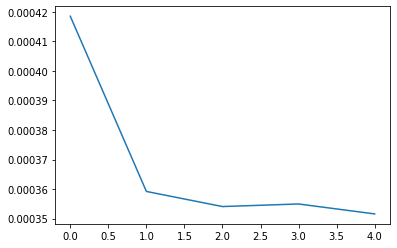

In [18]:
device = torch.device('cpu')

emblen = 300
epochs = 5
lr = 0.0003

crit = nn.CosineEmbeddingLoss(margin=0.5)

gnn = GNN(emblen, 1)
gnn.to(device)
optimizer = optim.Adam(gnn.parameters(), lr=lr)
lh = []

q = tqdm(total=0.1)



for epcq in tqdm(range(epochs)):
    el = 0
    for data in datasets:

        dl = 0
        bs = 256

        embs1 = emb_ents(data.ents1, data.g1)
        embs2 = emb_ents(data.ents2, data.g2)
        wi1 = WordMap(data.ents1)
        wi2 = WordMap(data.ents2)
        eadj1 = build_emb_adj(embs1, data.adj1)
        eadj2 = build_emb_adj(embs2, data.adj2)

        for e1, e2, s in tqdm(DataLoader(data, batch_size=bs), leave=False):
            optimizer.zero_grad()

            emm1 = dict()

            for e in e1:
                emm1[wi1[e]] = embs1[wi1[e]]

            emm2 = dict()
            for e in e2:
                emm2[wi2[e]] = embs2[wi2[e]]

            m1 = gnn(emm1, eadj1)
            m2 = gnn(emm2, eadj2)

            r1 = list(map(lambda x: m1[wi1[x]].unsqueeze(0), e1))
            r2 = list(map(lambda x: m2[wi2[x]].unsqueeze(0), e2))

            r1 = torch.cat(r1)
            r2 = torch.cat(r2)

            loss = crit(r1, r2, s.flatten())
            loss.backward()

            optimizer.step()
            dl += loss.item() * bs
            q.n = loss.item()
            q.refresh()
            # break

        dl /= len(data)
        el += dl

        # break

    el /= len(datasets)
    lh.append(el)
    torch.save(gnn.state_dict(), f'gnn-{epcq}.pt')
    # break

plt.plot(lh)
plt.show()


In [70]:
torch.save(gnn.state_dict(), 'gnn.pt')



In [21]:
gnn = GNN(emblen, 1)
gnn.load_state_dict(torch.load('gnn-0.pt'))

RuntimeError: Error(s) in loading state_dict for GNN:
	Missing key(s) in state_dict: "heads.0.w.weight", "heads.0.a.weight", "heads.0.a.bias", "ch.weight", "ch.bias". 
	Unexpected key(s) in state_dict: "an.0.heads.0.w.weight", "an.0.heads.0.a.weight", "an.0.heads.0.a.bias", "an.0.heads.0.pc.weight", "an.0.heads.0.pc.bias", "an.0.heads.1.w.weight", "an.0.heads.1.a.weight", "an.0.heads.1.a.bias", "an.0.heads.1.pc.weight", "an.0.heads.1.pc.bias", "an.0.ch.weight", "an.0.ch.bias", "an.1.heads.0.w.weight", "an.1.heads.0.a.weight", "an.1.heads.0.a.bias", "an.1.heads.0.pc.weight", "an.1.heads.0.pc.bias", "an.1.heads.1.w.weight", "an.1.heads.1.a.weight", "an.1.heads.1.a.bias", "an.1.heads.1.pc.weight", "an.1.heads.1.pc.bias", "an.1.ch.weight", "an.1.ch.bias". 

In [8]:
rang = np.arange(0.1, 1, 0.01)


class Matcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):

        ents1, adj1 = build_adj(dataset.g1)
        ents2, adj2 = build_adj(dataset.g2)
        embs1 = emb_ents(ents1, dataset.g1)
        embs2 = emb_ents(ents2, dataset.g2)

        wi1 = WordMap(ents1)
        wi2 = WordMap(ents2)

        eadj1 = build_emb_adj(embs1, adj1)
        eadj2 = build_emb_adj(embs2, adj2)


        ents = self.cross(dataset)

        res = [[] for r in rang]
        for e1, e2 in ents:

            emm1 = dict()

            emm1[wi1[e1]] = embs1[wi1[e1]]

            emm2 = dict()
            emm2[wi2[e2]] = embs2[wi2[e2]]

            with torch.no_grad():
                m1 = gnn(emm1, eadj1)
                m2 = gnn(emm2, eadj2)

            r1 = m1[wi1[e1]]
            r2 = m2[wi2[e2]]

            s = F.cosine_similarity(r1.unsqueeze(0), r2.unsqueeze(0)).item()
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}

class GloveMatcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):
        g1 = dataset.g1
        g2 = dataset.g2

        remove_bn(g1)
        remove_bn(g2)

        ents1 = set(g1.subjects())
        ents2 = set(g2.subjects())

        m1 = dict()

        for e1 in ents1:
            n1 = e1.n3(g1.namespace_manager)
            n1 = map(lambda x: x.lower(), split_entity(n1))
            n1 = list(map(lambda x: glove[x] if x in glove else torch.zeros((1, 300)), n1))
            ln = len(n1)
            sv = sum(n1) / ln

            m1[e1] = sv.squeeze(0)

        m2 = dict()

        for e1 in ents2:
            n1 = e1.n3(g2.namespace_manager)
            n1 = map(lambda x: x.lower(), split_entity(n1))
            n1 = list(map(lambda x: glove[x] if x in glove else torch.zeros((1, 300)), n1))
            ln = len(n1)
            sv = sum(n1) / ln

            m2[e1] = sv.squeeze(0)

        ents = self.cross(dataset)

        res = [[] for r in rang]
        for e1, e2 in ents:


            r1 = m1[e1]
            r2 = m2[e2]

            s = F.cosine_similarity(r1.unsqueeze(0), r2.unsqueeze(0)).item()
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}


eq match


  0%|          | 0/21 [00:00<?, ?it/s]

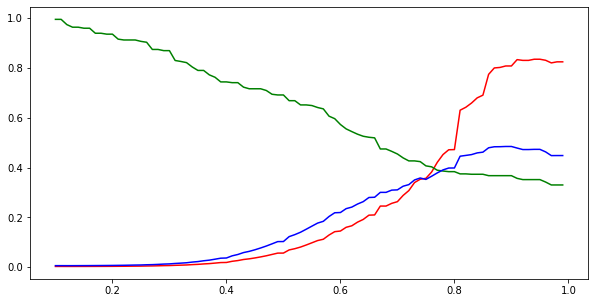

0.8899999999999996
                     name  precision    recall        f1
0   conference-iasted.rdf   0.666667  0.166667  0.266667
1         ekaw-iasted.rdf   1.000000  0.428571  0.600000
2      cmt-conference.rdf   0.571429  0.153846  0.242424
3          cmt-iasted.rdf   0.800000  1.000000  0.888889
4         confOf-ekaw.rdf   0.818182  0.290323  0.428571
5           edas-ekaw.rdf   0.733333  0.314286  0.440000
6       confOf-iasted.rdf   0.800000  0.285714  0.421053
7     conference-ekaw.rdf   0.642857  0.219512  0.327273
8            cmt-ekaw.rdf   0.833333  0.294118  0.434783
9         edas-iasted.rdf   0.888889  0.266667  0.410256
10        edas-sigkdd.rdf   1.000000  0.304348  0.466667
11         cmt-confOf.rdf   0.666667  0.142857  0.235294
12      confOf-sigkdd.rdf   1.000000  0.400000  0.571429
13        ekaw-sigkdd.rdf   1.000000  0.466667  0.636364
14         cmt-sigkdd.rdf   0.818182  0.600000  0.692308
15    conference-edas.rdf   0.777778  0.259259  0.388889
16          

In [9]:
# print('=' * 100)
# print('kgome')
# print('=' * 100)
#
# runner = Runner('conference', 'reference', matcher=Matcher())
# result = runner.run(parallel=False)
#
# eval_result(result, rang)


# print('=' * 100)
# print('glove')
# print('=' * 100)
#
# runner = Runner('conference', 'reference', matcher=GloveMatcher())
# result = runner.run(parallel=False)
#
# eval_result(result, rang)
#
print('=' * 100)
print('eq match')
print('=' * 100)

runner = Runner('conference', 'reference', matcher=EqMatcher())

result = runner.run(parallel=False)

eval_result(result, rang)